# Discrete areas

Split area into discrete regions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from h3 import h3

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

## Prepare data

In [51]:
%%time 

data = pd.read_feather('structured_data.feather')

data = data.sample(1000000)

data.head()

CPU times: user 5.42 s, sys: 8 s, total: 13.4 s
Wall time: 19.3 s


,datetime,lon,lat
13189478,2015-02-07 20:05:37,-73.975,40.752
56958522,2015-06-07 00:04:05,-73.984,40.755
60703964,2015-06-17 19:55:01,-73.986,40.759
60777640,2015-06-17 23:11:22,-73.991,40.756
12865004,2015-02-07 00:20:45,-73.959,40.764


## Points to h3 indexes

In [53]:
%%time

def point_h3_indexes(points: pd.DataFrame, res: int) -> np.ndarray:
    """Create h3 indexes for each lat-lon pair in points"""
    
    h3_indexes = points.apply(
        lambda point: h3.geo_to_h3(point['lat'], point['lon'], res),
        axis=1
    )
    return h3_indexes
    
data['h3_res8'] = point_h3_indexes(data, 8)
data['h3_res9'] = point_h3_indexes(data, 9)

CPU times: user 1min 1s, sys: 553 ms, total: 1min 2s
Wall time: 1min 3s


## Choropleth map

Count the number of points per area and color hexagons according to the number

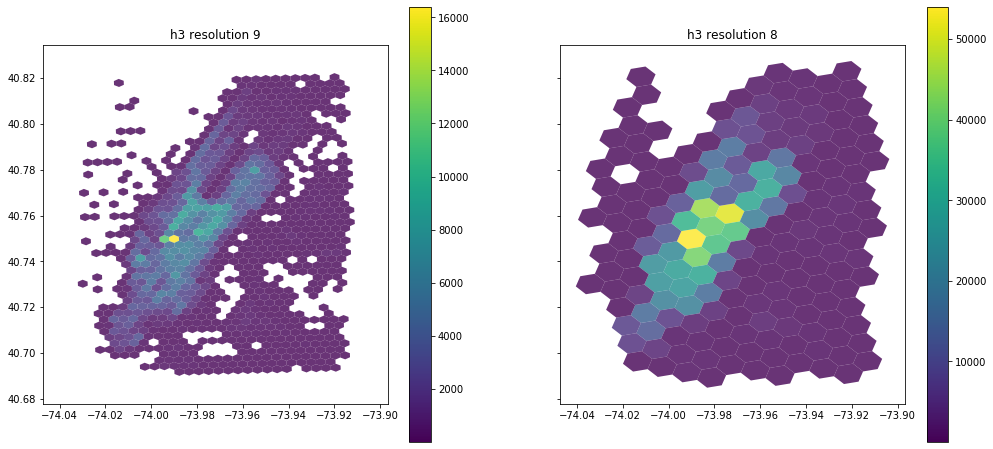

In [172]:
from shapely.geometry import Polygon
import geopandas as gpd


def h3_to_polygon(item) -> Polygon:
    """Convert h3 index to shapely polygon"""
    h3_index = item['index']
    boundary = h3.h3_to_geo_boundary(h3_address=h3_index, geo_json=True)
    return Polygon(boundary)


fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

# plot hexagons with resolution 9
counts = data.h3_res9.value_counts()
counts = counts.to_frame(name='total').reset_index()

geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
geo_df.plot(column='total', alpha=0.8, legend=True, ax=ax1)
ax1.set_title('h3 resolution 9')

# plot hexagons with resolution 8
counts = data.h3_res8.value_counts()
counts = counts.to_frame(name='total').reset_index()

geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
geo_df.plot(column='total', alpha=0.8, legend=True, ax=ax2)
ax2.set_title('h3 resolution 8');

## Interactive map

Create an interactive map using _folium_ to plot hexagons with different resolutions

In [55]:
import geojson
from geojson import FeatureCollection
import folium

def indexes_to_polygons(h3_indexes):
    polygons = []
    
    for h in h3_indexes:
        polygon = Polygon(h3.h3_to_geo_boundary(h3_address=h, geo_json=True))
        polygons.append(polygon)
        
    feature_collection = FeatureCollection(polygons)
    return geojson.dumps(feature_collection)
        
def create_style_fn(color, opacity=0.1, weight=2):
    """Ugly way to set color of json features"""
    
    return lambda feature: {
        'fillColor': None,
        'color': color,
        'weight': weight,
        'fillOpacity': opacity
    }

m = folium.Map(location=[40.7536, -73.9811], zoom_start=12)

# resolution 8
feature_collection = indexes_to_polygons(data.h3_res8.unique())
folium.GeoJson(
    feature_collection, 
    style_function=create_style_fn('blue', opacity=0.1, weight=2), 
    ).add_to(m)

# resolution 9
feature_collection = indexes_to_polygons(data.h3_res9.unique())
folium.GeoJson(
    feature_collection, 
    style_function=create_style_fn('green', opacity=0., weight=1)
    ).add_to(m)

m

## Points per area

Plot distribution of number of points per each area

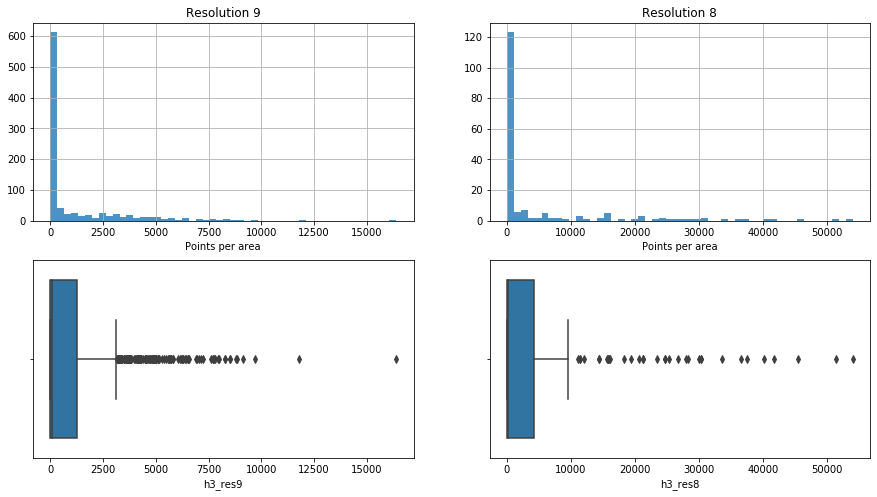

In [107]:
plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.title('Resolution 9')
data.h3_res9.value_counts().hist(bins=50, alpha=0.8);
plt.xlabel('Points per area')

plt.subplot(223)
sns.boxplot(data.h3_res9.value_counts());

plt.subplot(222)
plt.title('Resolution 8')
data.h3_res8.value_counts().hist(bins=50, alpha=0.8);
plt.xlabel('Points per area')

plt.subplot(224)
sns.boxplot(data.h3_res8.value_counts());

Histograms how that the data is largely skewed to the right. It looks noise, let's check basic statistics of the data:

In [215]:
h9_total = data.h3_res9.value_counts().to_frame('total').reset_index()

h9_total.total.describe()

count      931.000
mean      1074.114
std       1956.506
min          1.000
25%          5.500
50%         55.000
75%       1258.500
max      16392.000
Name: total, dtype: float64

## Remove noise

More than half of the areas contain really small number of points. The question is what is _small_ and how to find a cut-off point that separate noise from somehow interesting data - areas where demand prediction makes sense, especially from business point of view (it doesn't make sense to consider areas where the total number of point is, for example, around hundred in 6 month whereas some area contain thousand of points per week).

As simple heuristic is to only consider areas where something happens every day - there are at least one point per day per area for the whole time range of the dataset.

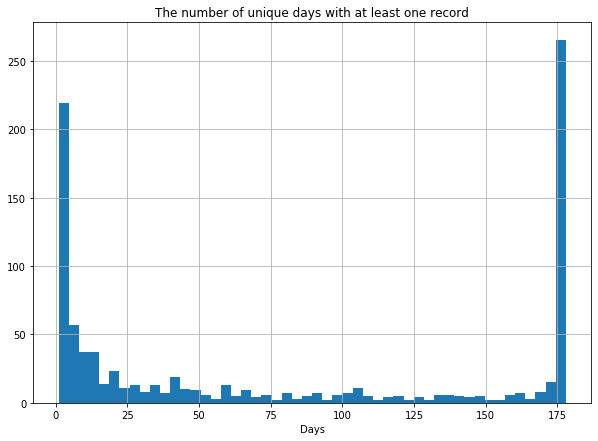

In [300]:
# count number of points per area per day
daily_total = data.groupby(['h3_res9', data.datetime.dt.date]).h3_res9.count()

# convert to dataframe
daily_total = daily_total.to_frame('total').reset_index()

# calculate aggregations
daily_agg = daily_total.groupby('h3_res9').agg({'total': ['sum', 'mean', 'count']})

# plot the number of unique days with at least one record
daily_agg.total['count'].hist(bins=50);

plt.title('The number of unique days with at least one record');
plt.xlabel('Days');

In [305]:
# filter out areas with the number of days with events less than 
# the total number of days
outliers_index = daily_agg.total['count'] < data.datetime.dt.date.nunique()

outliers = daily_agg[outliers_index].index.tolist()

outliers[:5]

['892a1008803ffff',
 '892a100880fffff',
 '892a1008813ffff',
 '892a1008833ffff',
 '892a1008863ffff']

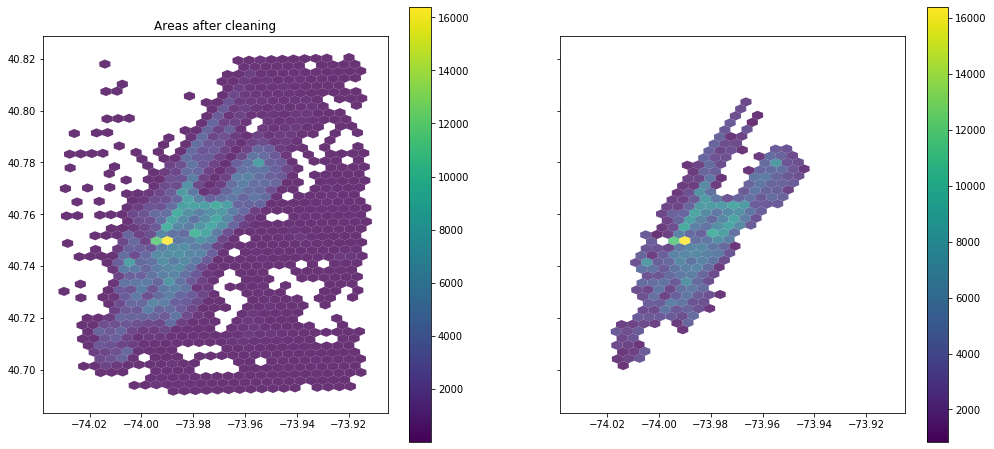

In [312]:
data_clean = data[~data.h3_res9.isin(outliers)]

fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

ax1.set_title('Areas before cleaning')
counts = data.h3_res9.value_counts()
counts = counts.to_frame(name='total').reset_index()
geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
geo_df.plot(column='total', alpha=0.8, legend=True, ax=ax1);

ax1.set_title('Areas after cleaning')
counts = data_clean.h3_res9.value_counts()
counts = counts.to_frame(name='total').reset_index()
geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
geo_df.plot(column='total', alpha=0.8, legend=True, ax=ax2);

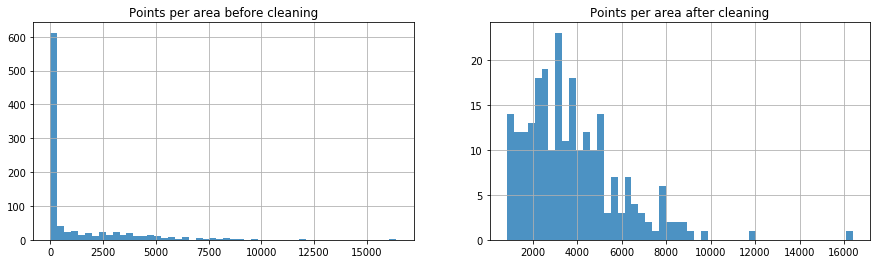

In [318]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.title('Points per area before cleaning')
data.h3_res9.value_counts().hist(bins=50, alpha=0.8);

plt.subplot(122)
plt.title('Points per area after cleaning')
data_clean.h3_res9.value_counts().hist(bins=50, alpha=0.8);